## Notebook for running single training and compare them

Imports and set seed optionally:

In [1]:
import torch
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from spirals_data_new import plot_decision_boundary, gen_spiral_dataset
from torchvision.transforms import ToTensor


from layer_insertion_loop import layer_insertion_loop
from train_and_test_ import train, check_testerror
from nets import feed_forward, two_weight_resnet, one_weight_resnet
from utils import ema

h=random.randint(0,100)
print(h)
random.seed(h)
np.random.seed(h)
torch.manual_seed(h)

torch.set_num_threads(8)

Running on CPU!
Current working directory:  /home/leonie/codes/layer_insertion_sensitivity_based
Removed previously created data directory & contents
New data directory created
['val_at_li2023-11-16_16-24-43-416270.txt', 'li_experiments_spirals.ipynb', 'val_at_li2023-11-16_15-44-24-330680.txt', 'val_at_li2023-11-17_10-27-55-908873.txt', 'val_at_li2023-11-16_12-21-17-447521.txt', 'val_at_li2023-11-17_5-40-54-97698.txt', 'utils.py', 'val_at_li2023-11-17_8-21-7-706924.txt', 'val_at_li2023-11-17_4-34-13-110077.txt', 'val_at_li2023-11-17_1-46-39-855922.txt', 'val_at_li2023-11-17_6-28-32-884683.txt', 'val_at_li2023-11-17_3-53-6-869584.txt', 'val_at_li2023-11-16_19-17-2-342458.txt', 'val_at_li2023-11-17_2-18-14-906014.txt', 'val_at_li2023-11-16_12-11-46-997710.txt', 'val_at_li2023-11-17_9-38-53-145051.txt', 'val_at_li2023-11-16_15-49-15-723561.txt', 'val_at_li2023-11-17_4-26-0-863625.txt', 'val_at_li2023-11-16_14-16-6-823562.txt', 'val_at_li2023-11-17_3-42-18-227303.txt', 'val_at_li2023-11-17

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
batchsize = 450
no_per_class = 300
r0=0.5
circles = 1

In [4]:
td, vd, data_X, data_y = gen_spiral_dataset(batchsize,no_per_class,r0,circles)

Running on CPU!
Current working directory:  /home/leonie/codes/layer_insertion_sensitivity_based
Removed previously created data directory & contents
New data directory created
['val_at_li2023-11-16_16-24-43-416270.txt', 'li_experiments_spirals.ipynb', 'val_at_li2023-11-16_15-44-24-330680.txt', 'val_at_li2023-11-17_10-27-55-908873.txt', 'val_at_li2023-11-16_12-21-17-447521.txt', 'val_at_li2023-11-17_5-40-54-97698.txt', 'utils.py', 'val_at_li2023-11-17_8-21-7-706924.txt', 'val_at_li2023-11-17_4-34-13-110077.txt', 'val_at_li2023-11-17_1-46-39-855922.txt', 'val_at_li2023-11-17_6-28-32-884683.txt', 'val_at_li2023-11-17_3-53-6-869584.txt', 'val_at_li2023-11-16_19-17-2-342458.txt', 'val_at_li2023-11-17_2-18-14-906014.txt', 'val_at_li2023-11-16_12-11-46-997710.txt', 'val_at_li2023-11-17_9-38-53-145051.txt', 'val_at_li2023-11-16_15-49-15-723561.txt', 'val_at_li2023-11-17_4-26-0-863625.txt', 'val_at_li2023-11-16_14-16-6-823562.txt', 'val_at_li2023-11-17_3-42-18-227303.txt', 'val_at_li2023-11-17

Define and list hyperparameters:

In [5]:
no_hidden_layers_start = 2
fix_width = [3,3]
no_iters = 1
lr_decrease_after_li =0.5 #1.0#0.8
epochs = [500,1500]
wanted_testerror = 0.
_type = 'fwd'#'res2'
act_fun = nn.ReLU
interval_testerror = 1

save_grad_norms = True

lr_init = 2e-1
optimizer_type = 'SGD'
lrscheduler_type = 'StepLR'
lrscheduler_args = {'step_size': 4000,
                    'gamma': 0.1}


# for classical 
epochs_classical = sum(epochs)
lr_init_classical = lr_init
lrscheduler_args_classical = {'step_size': 4000,
                    'gamma': 0.1}

Build models:

In [6]:
kwargs_net ={
        'hidden_layers': no_hidden_layers_start,
        'dim_hidden_layers': fix_width,
        'act_fun': act_fun,
        'type': _type,
    'flatten': True
}

dim_in = 2 
dim_out = 2

In [7]:
# classical net
kwargs_net_classical = {
    'hidden_layers': 2,
    'dim_hidden_layers': fix_width,
    'act_fun': act_fun,
    'type': _type,
    'flatten': True
}

Determine which trainings are run:

In [8]:
T1 = True
T2 = True
T3 = True

## Training with layer insertion:

In [9]:
# build model
if _type=='fwd':
    model_init = feed_forward(dim_in, dim_out,**kwargs_net)
if _type=='res2':
    model_init = two_weight_resnet(dim_in, dim_out,**kwargs_net)
if _type=='res1':
    model_init = one_weight_resnet(dim_in, dim_out,**kwargs_net)

param_init = torch.nn.utils.parameters_to_vector(model_init.parameters())
param_init = copy.deepcopy(param_init.data)
param_init_class = copy.deepcopy(param_init.data)

Check initial test error of the model

In [10]:
print(check_testerror(vd,model_init))
initial_train_acc = check_testerror(td,model_init)
print(check_testerror(td,model_init))

49.33333333333333
50.22222222222222


In [11]:
for X,y in vd:
    print(X.shape)
    print(y.shape)
    #print(y)

torch.Size([150, 2])
torch.Size([150])


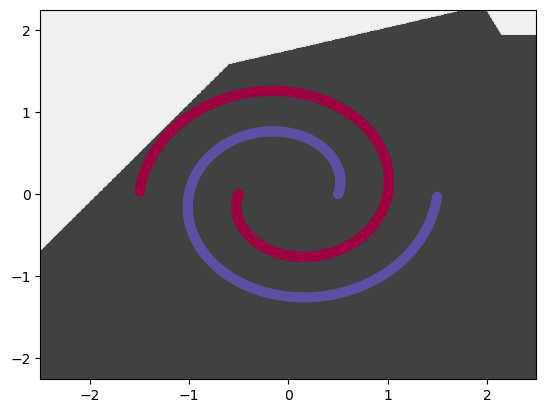

In [12]:
plot_decision_boundary(model_init, data_X, data_y)

In [13]:
# train ali 1
if T1:
    model1, mb_losses1, test_errors_short1, test_errors1, exit_flag1, grad_norms1 = layer_insertion_loop(
        iters=no_iters,
        epochs=epochs,
        model= model_init,
        kwargs_net=kwargs_net,
        dim_in=dim_in,
        dim_out=dim_out,
        train_dataloader=td,
        test_dataloader=vd,
        lr_init=lr_init,
        wanted_test_error=wanted_testerror,
        mode='abs max',
        optimizer_type=optimizer_type,
        lrschedule_type=lrscheduler_type,
        lrscheduler_args=lrscheduler_args,
        check_testerror_between=interval_testerror,
        decrease_after_li=lr_decrease_after_li,
        print_param_flag=False,
        start_with_backtracking=None,
        v2=False,
        save_grad_norms=save_grad_norms
    ) 

starting on 1. net !
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2, out_features=3, bias=True)
  (2): ReLU()
  (3): Linear(in_features=3, out_features=3, bias=True)
  (4): ReLU()
  (5): Linear(in_features=3, out_features=2, bias=True)
)


mbloss:  0.6936866044998169
(dataset)error at epoch 0 is 49.33333333333333
mbloss:  0.6936181783676147
(dataset)error at epoch 1 is 54.66666666666667
mbloss:  0.6935560703277588
(dataset)error at epoch 2 is 57.33333333333333
mbloss:  0.6934990286827087
(dataset)error at epoch 3 is 58.666666666666664
mbloss:  0.6934458613395691
(dataset)error at epoch 4 is 59.333333333333336
mbloss:  0.693395733833313
(dataset)error at epoch 5 is 59.333333333333336
mbloss:  0.6933481097221375
(dataset)error at epoch 6 is 58.666666666666664
mbloss:  0.6933027505874634
(dataset)error at epoch 7 is 58.0
mbloss:  0.6932588219642639
(dataset)error at epoch 8 is 56.666666666666664
mbloss:  0.6932164430618286
(dataset)error at epoch 9 is 49.33333333333333
mbloss:  0.6931751370429993
(dataset)error at epoch 10 is 49.33333333333333
mbloss:  0.6931349039077759
(dataset)error at epoch 11 is 49.33333333333333
mbloss:  0.6930956244468689
(dataset)error at epoch 12 is 49.33333333333333
mbloss:  0.693057119846344
(dat

In [14]:
if T1:
    print('test error: ',check_testerror(vd, model1))
    train_acc = check_testerror(td, model1)
    print('train error: ',train_acc)

test error:  28.0
train error:  26.66666666666667


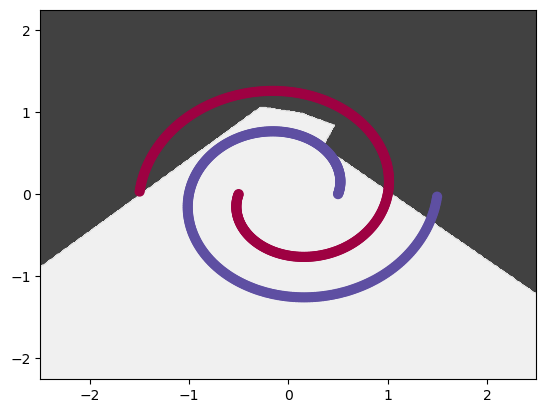

In [15]:
if T1:
    #plot_decision_boundary(model1, X_small,y_small)
    plot_decision_boundary(model1,data_X,data_y)

plot results:

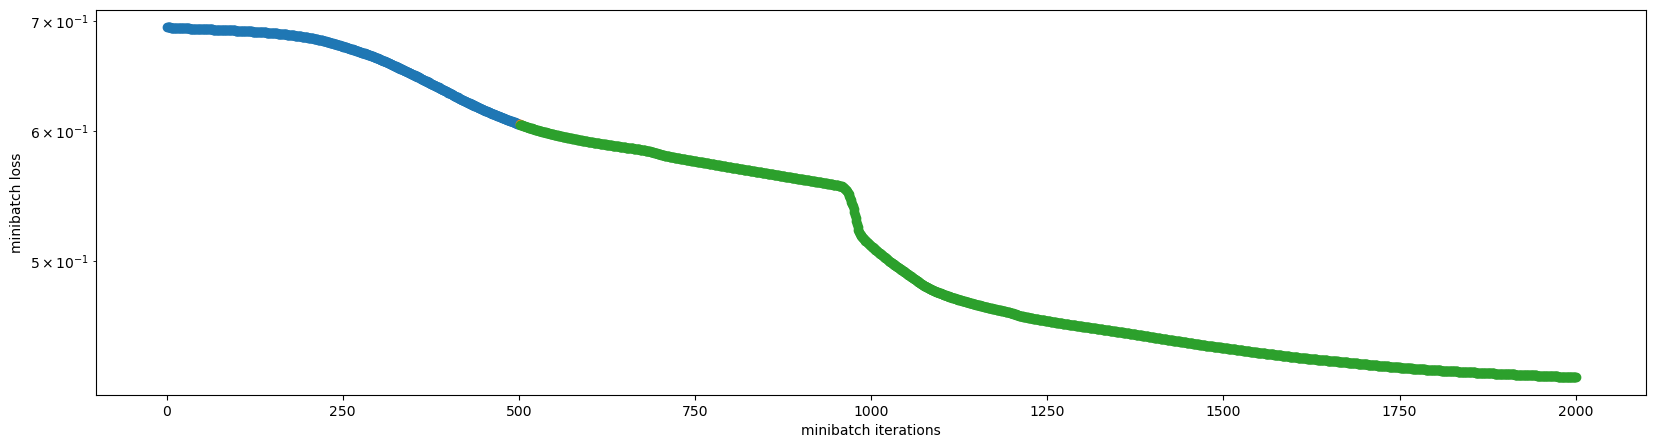

In [16]:
end_list=[]
for i,e in enumerate(epochs):
    end_list.append(int(e*len(td)))
    end_list.append(1) 
end_list.pop() # removes last 1 which was too much

# todo plot
if T1:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(mb_losses1)+1)
    yfull = mb_losses1
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('minibatch loss')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(mb_losses1)))

In [17]:
#print(len(grad_norms1[1]))

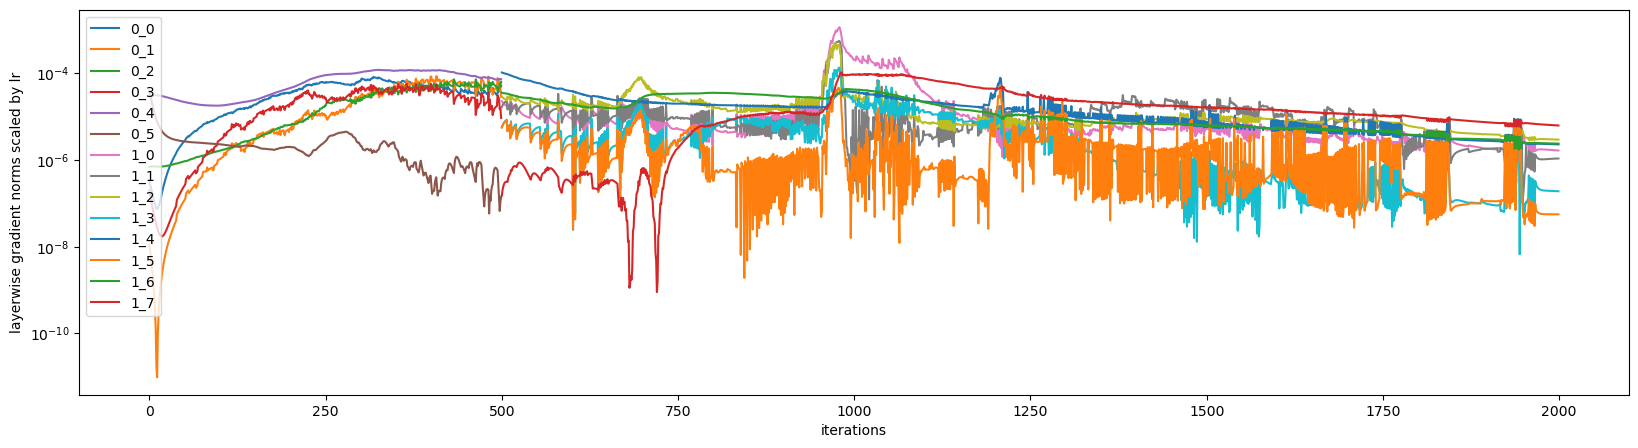

In [19]:
if True:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms1[0])
    l2 = len(grad_norms1[1])
    len_t1 = len(grad_norms1[0][0])
    len_t2 = len(grad_norms1[1][0])
    for i in range(l1):
        plt.plot(grad_norms1[0][i], label=f'0_{i}')
    for j in range(l2):
        #print(list(range(len_t1,len_t2+len_t1)))
        plt.plot(list(range(len_t1,len_t2+len_t1)), grad_norms1[1][j], label=f'1_{j}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')
    #plt.xlim(900,1100)

In [ ]:
# todo plot
if False:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(grad_norms1)+1)
    yfull = grad_norms1
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('squared grad norm')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(grad_norms1)))

Text(0.5, 0, 'epochs')

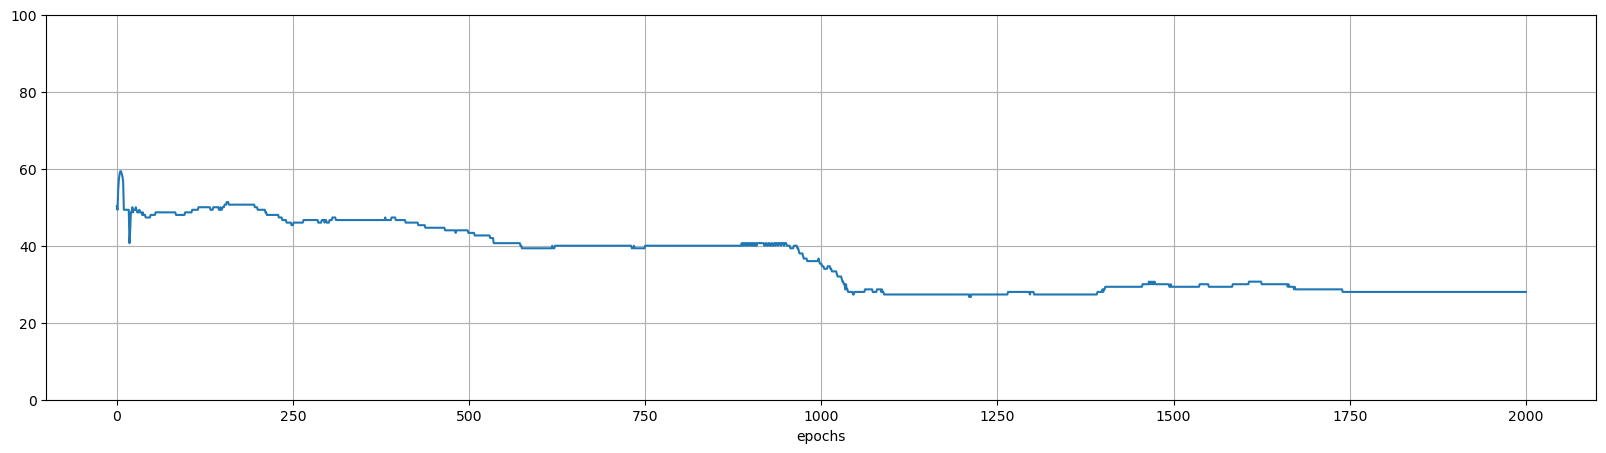

In [20]:
plt.figure(figsize=(20,5))
plt.plot([initial_train_acc]+test_errors1)#,'o')
plt.ylim(top=100,bottom=0)
plt.grid()
plt.xlabel('epochs')

## Second training

In [21]:
# build net
if _type=='fwd':
    model_init2 = feed_forward(dim_in, dim_out,**kwargs_net)
if _type=='res2':
    model_init2 = two_weight_resnet(dim_in, dim_out,**kwargs_net)
if _type=='res1':
    model_init2 = one_weight_resnet(dim_in, dim_out,**kwargs_net)

torch.nn.utils.vector_to_parameters(param_init, model_init2.parameters())

In [22]:
print(check_testerror(vd,model_init2))
initial_train_acc2 = check_testerror(td,model_init2)
print(check_testerror(td,model_init2))

49.33333333333333
50.22222222222222


In [23]:
if T2:
    model2, mb_losses2, test_errors_short2, test_errors2, exit_flag2, grad_norms2 = layer_insertion_loop(
        iters=no_iters,
        epochs=epochs,
        model= model_init2,
        kwargs_net=kwargs_net,
        dim_in=dim_in,
        dim_out=dim_out,
        train_dataloader=td,
        test_dataloader=vd,
        lr_init=lr_init,
        wanted_test_error=wanted_testerror,
        mode='abs min',#'threshold',
        optimizer_type=optimizer_type,
        lrschedule_type=lrscheduler_type,
        lrscheduler_args=lrscheduler_args,
        check_testerror_between=interval_testerror,
        decrease_after_li=lr_decrease_after_li,
        print_param_flag=False,
        start_with_backtracking=None,
        v2=False,
        save_grad_norms=save_grad_norms
    ) 

starting on 1. net !
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2, out_features=3, bias=True)
  (2): ReLU()
  (3): Linear(in_features=3, out_features=3, bias=True)
  (4): ReLU()
  (5): Linear(in_features=3, out_features=2, bias=True)
)
mbloss:  0.6936866641044617
(dataset)error at epoch 0 is 49.33333333333333
mbloss:  0.6936182379722595
(dataset)error at epoch 1 is 54.66666666666667
mbloss:  0.6935561299324036
(dataset)error at epoch 2 is 57.33333333333333
mbloss:  0.693498969078064
(dataset)error at epoch 3 is 58.666666666666664
mbloss:  0.6934458613395691
(dataset)error at epoch 4 is 59.333333333333336
mbloss:  0.693395733833313
(dataset)error at epoch 5 is 59.333333333333336
mbloss:  0.6933481693267822
(dataset)error at epoch 6 is 58.666666666666664
mbloss:  0.6933026909828186
(dataset)error at epoch 7 is 58.0
mbloss:  0.6932588219642639
(dataset)error at epoch 8 is 56.666666666666664
mbloss:  0.6932164430618286
(dataset)error at epoch 9 is 49.3333

In [24]:
if T2:
    print('test error: ',check_testerror(vd, model2))
    print('train error: ',check_testerror(td, model2))

test error:  19.333333333333343
train error:  19.333333333333343


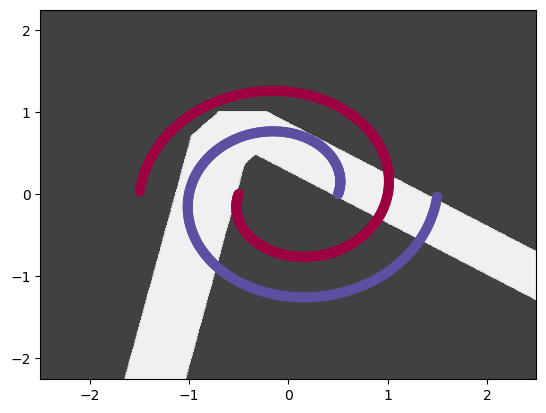

In [25]:
plot_decision_boundary(model2, data_X, data_y)

plot results:

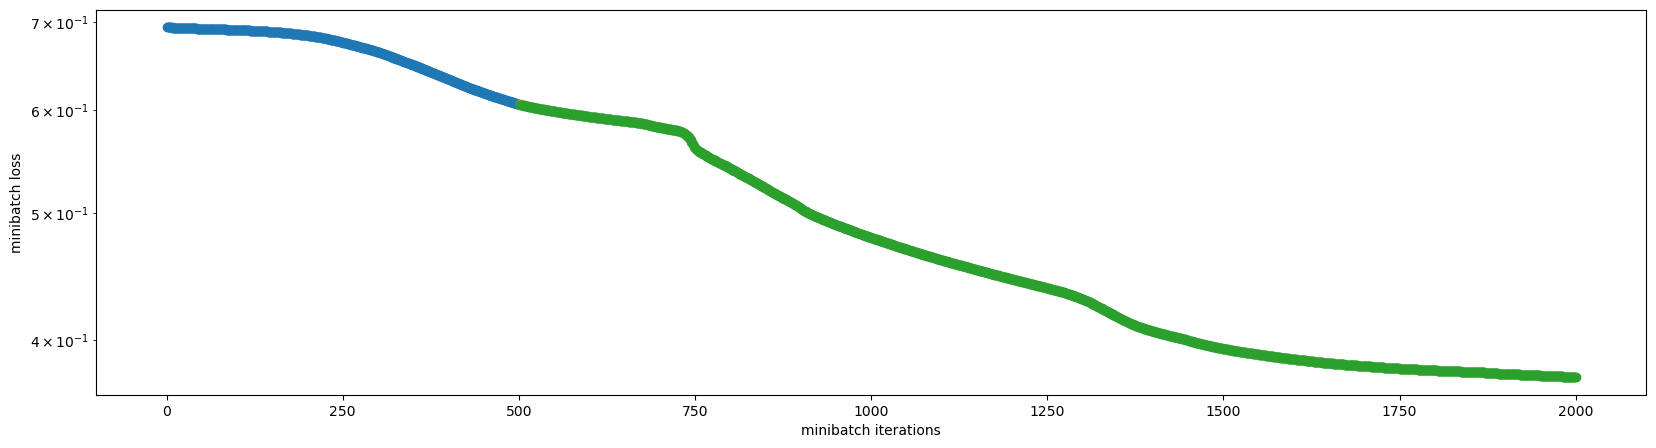

In [26]:
# todo plot
if T2:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(mb_losses2)+1)
    yfull = mb_losses2
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('minibatch loss')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(mb_losses2)))

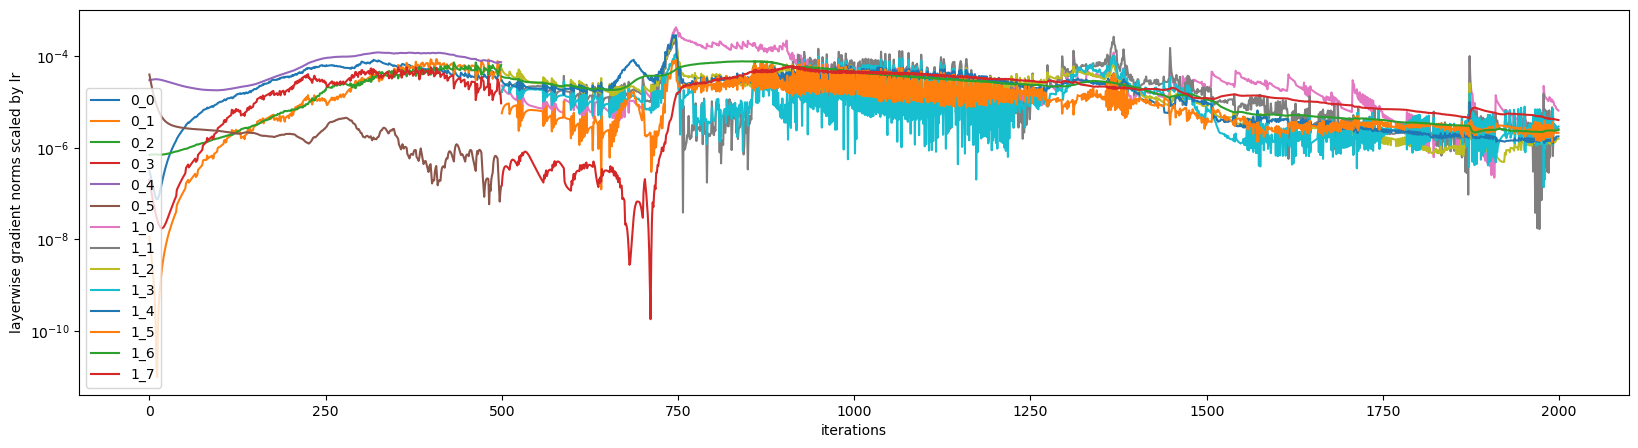

In [27]:
if True and T2:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms2[0])
    l2 = len(grad_norms2[1])
    len_t1 = len(grad_norms2[0][0])
    len_t2 = len(grad_norms2[1][0])
    for i in range(l1):
        plt.plot(grad_norms2[0][i], label=f'0_{i}')
    for j in range(l2):
        #print(list(range(len_t1,len_t2+len_t1)))
        plt.plot(list(range(len_t1,len_t2+len_t1)), grad_norms2[1][j],label=f'1_{j}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')
    #plt.xlim(900,1100)

In [28]:
# todo plot
if False:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(grad_norms2)+1)
    yfull = grad_norms2
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('squared grad norm')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(grad_norms2)))

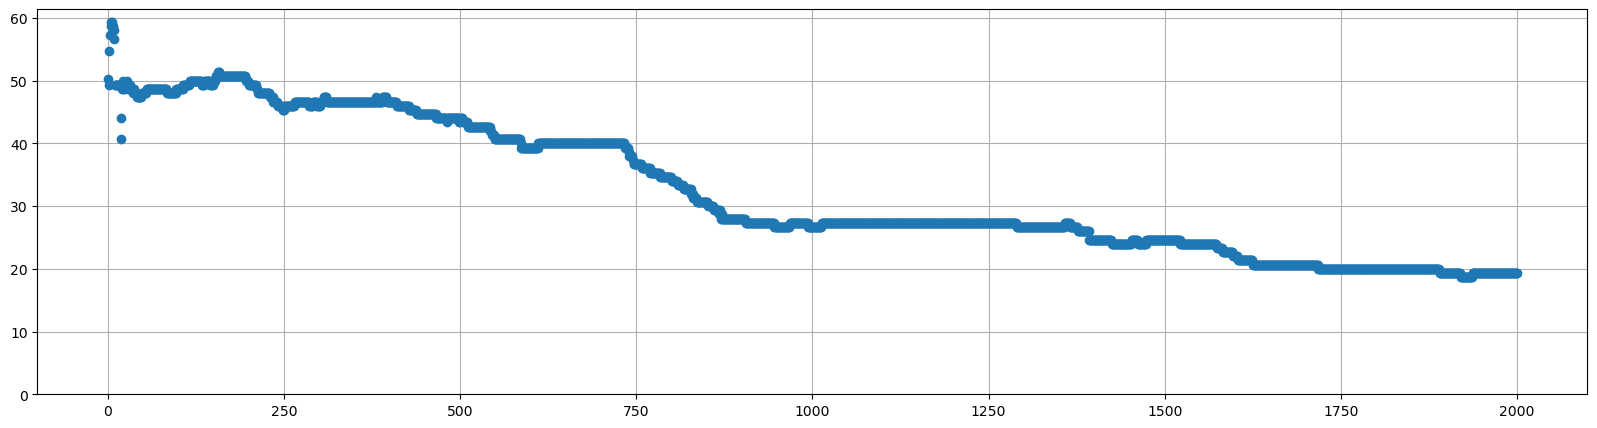

In [29]:
if T2:
    plt.figure(figsize=(20,5))
    #plt.ylim((0,100))
    plt.plot([initial_train_acc2]+test_errors2,'o')
    plt.ylim(bottom=0)
    plt.grid()

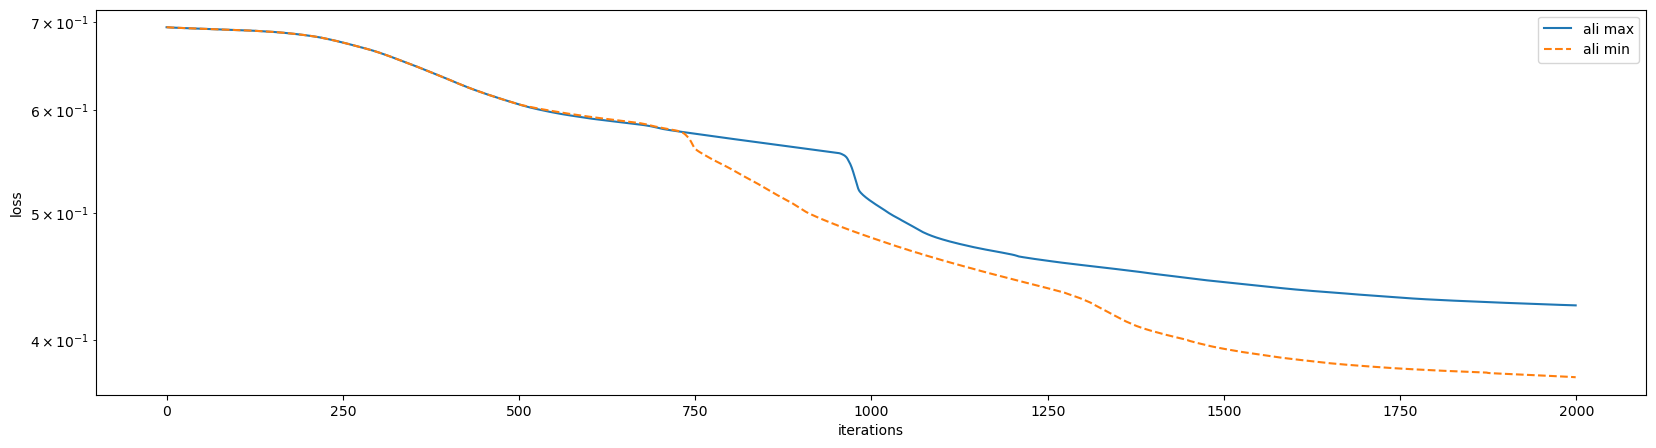

In [30]:
plt.figure(figsize=(20,5))

plt.plot(mb_losses1,label='ali max')
if T2:
    plt.plot(mb_losses2, '--',label='ali min')
plt.xlabel('iterations')
plt.ylabel('loss')

plt.yscale('log')

plt.legend()
#plt.ylim((1e-8,1.1))
#plt.xlim((80,100))
plt.show()

## Third training

In [31]:
# build model
if _type=='fwd':
    model_classical = feed_forward(dim_in, dim_out,**kwargs_net_classical)
if _type=='res2':
    model_classical = two_weight_resnet(dim_in, dim_out,**kwargs_net_classical)
if _type=='res1':
    model_classical = one_weight_resnet(dim_in, dim_out,**kwargs_net_classical)

torch.nn.utils.vector_to_parameters(param_init_class,model_classical.parameters())

In [32]:
print('test error: ',check_testerror(vd, model_classical))
print('train error: ',check_testerror(td, model_classical))
initial_train_acc_class = check_testerror(td, model_classical)

test error:  49.33333333333333
train error:  50.22222222222222


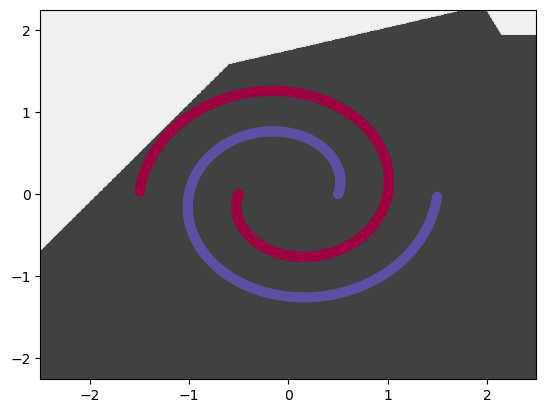

In [33]:
plot_decision_boundary(model_classical, data_X, data_y)

In [34]:
# build optimizer
if optimizer_type == 'SGD':
    optimizer_classical = torch.optim.SGD(model_classical.parameters(), lr_init_classical)
if optimizer_type == 'Adam':
    optimizer_classical = torch.optim.Adam(model_classical.parameters(), lr_init_classical)

# build lr scheduler
if lrscheduler_type == 'StepLR':
    step_size = lrscheduler_args_classical['step_size']
    gamma = lrscheduler_args_classical['gamma']
    lrscheduler_classical = torch.optim.lr_scheduler.StepLR(
            optimizer_classical, step_size=step_size, gamma=gamma)


In [35]:
if T3:
    print('training classically on model', model_classical)
    mblosses_classical, lr_end, test_error_classical, exit_flag_classical, grad_norms_classical = train(model_classical,
                                                             train_dataloader=td,
                                                             epochs=epochs_classical,
                                                             optimizer=optimizer_classical,
                                                             scheduler=lrscheduler_classical,
                                                             wanted_testerror=wanted_testerror,
                                                             start_with_backtracking=None,
                                                             check_testerror_between=interval_testerror,
                                                             test_dataloader=vd,
                                                             print_param_flag=False,
                                                             save_grad_norms=save_grad_norms
                                                             )

training classically on model Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2, out_features=3, bias=True)
  (2): ReLU()
  (3): Linear(in_features=3, out_features=3, bias=True)
  (4): ReLU()
  (5): Linear(in_features=3, out_features=2, bias=True)
)
mbloss:  0.6936867237091064
(dataset)error at epoch 0 is 49.33333333333333
mbloss:  0.6936181783676147
(dataset)error at epoch 1 is 54.66666666666667
mbloss:  0.6935560703277588
(dataset)error at epoch 2 is 57.33333333333333
mbloss:  0.6934990286827087
(dataset)error at epoch 3 is 58.666666666666664
mbloss:  0.6934458613395691
(dataset)error at epoch 4 is 59.333333333333336
mbloss:  0.6933957934379578
(dataset)error at epoch 5 is 59.333333333333336
mbloss:  0.6933481693267822
(dataset)error at epoch 6 is 58.666666666666664
mbloss:  0.6933026909828186
(dataset)error at epoch 7 is 58.0
mbloss:  0.6932588219642639
(dataset)error at epoch 8 is 56.666666666666664
mbloss:  0.6932164430618286
(dataset)error at epoch 9

plot results:

In [ ]:
if T3:
    print('test error: ',check_testerror(vd, model_classical))
    print('train error: ',check_testerror(td, model_classical))

test error:  14.0
train error:  14.666666666666657


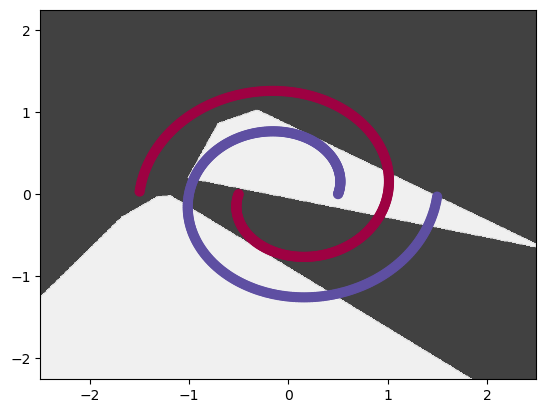

In [ ]:
plot_decision_boundary(model_classical, data_X, data_y)

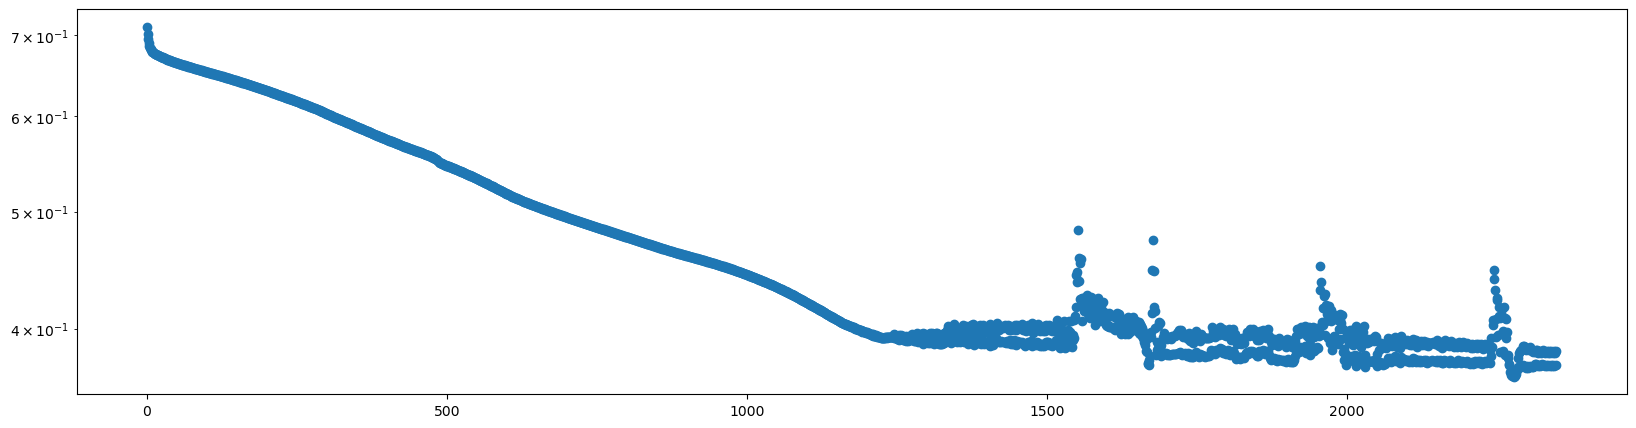

In [ ]:
if T3:
    plt.figure(figsize=(20,5))
    plt.plot(mblosses_classical,'o')
    plt.yscale('log')
    
    #plt.xlim((-10,3000))
    #plt.ylim((0.68,0.8))

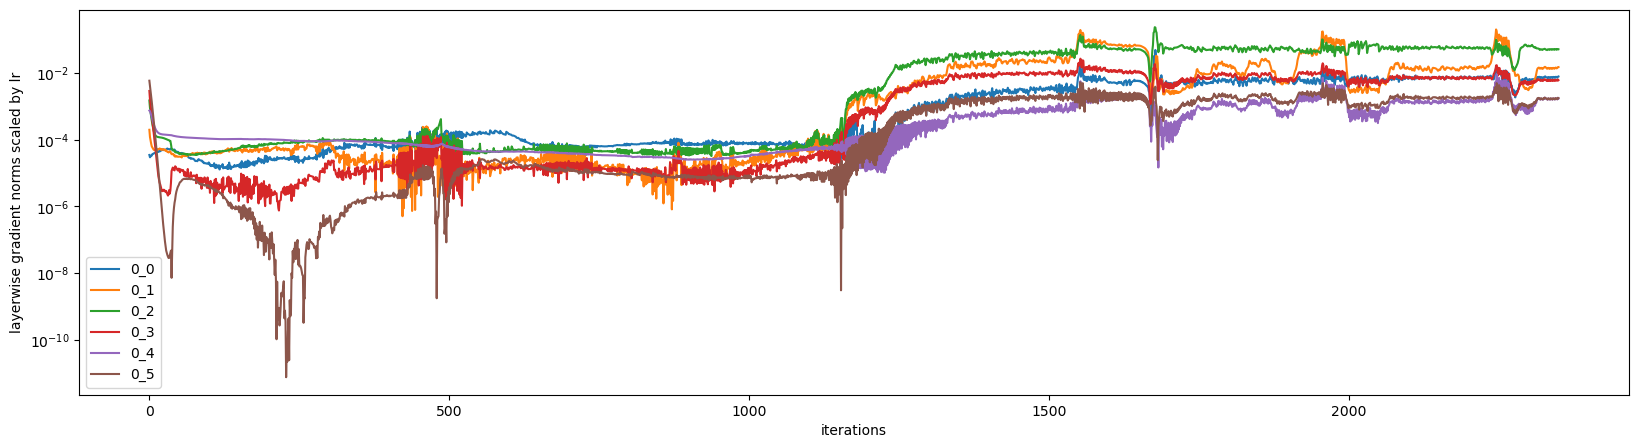

In [ ]:
if True:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms_classical)
    for i in range(l1):
        plt.plot(grad_norms_classical[i], label=f'0_{i}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')

In [ ]:
if False:
    plt.figure(figsize=(20,5))
    plt.plot(grad_norms_classical,'o')
    plt.yscale('log')

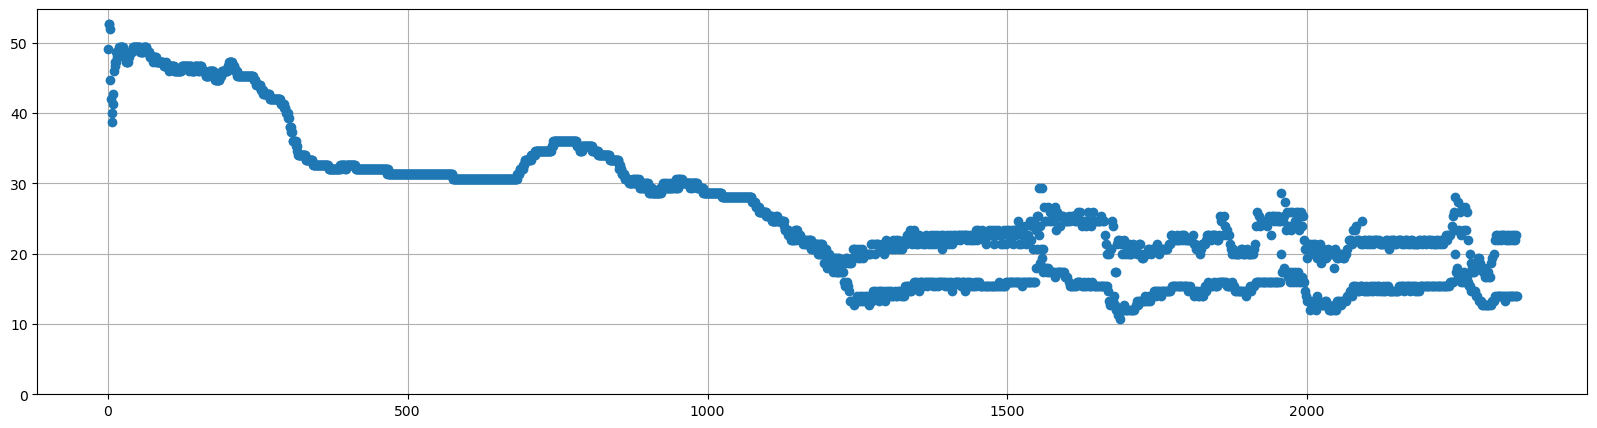

In [ ]:
if T3:
    plt.figure(figsize=(20,5))
    plt.plot([initial_train_acc_class]+test_error_classical,'o')
    plt.ylim(bottom=0)
    plt.grid()

## Comparison of the trainings as plot:


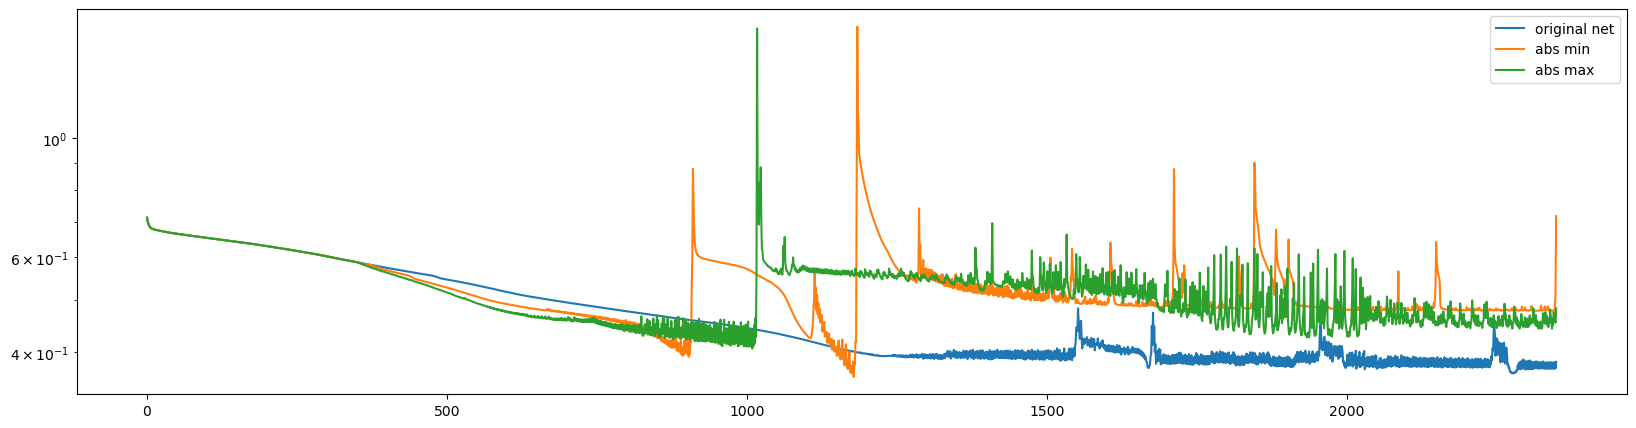

In [ ]:
plt.figure(figsize=(20,5))

#if T2:
#    plt.plot(np.zeros(max(len(mb_losses1),len(mb_losses2))))#,len(mblosses_classical))))
if T3:
    plt.plot(mblosses_classical, label='original net')
if T2:
    plt.plot(mb_losses2, label='abs min')
plt.plot(mb_losses1,label='abs max')

plt.yscale('log')

plt.legend()
#plt.ylim((1e-8,1.1))
#plt.xlim((80,100))
plt.show()

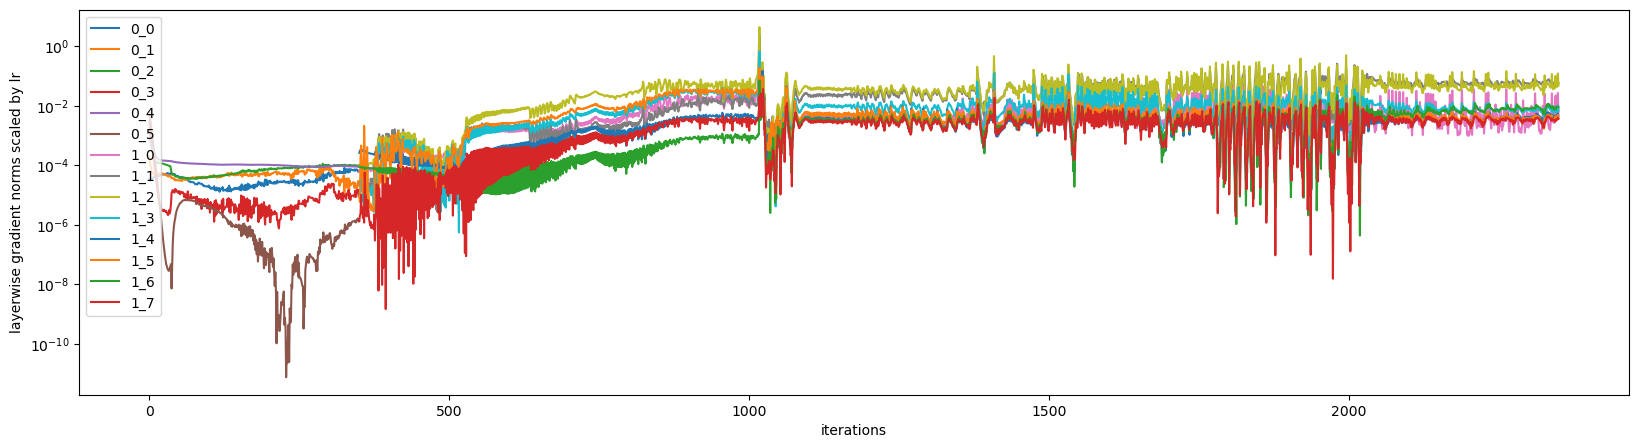

In [ ]:
# li
if True:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms1[0])
    l2 = len(grad_norms1[1])
    len_t1 = len(grad_norms1[0][0])
    len_t2 = len(grad_norms1[1][0])
    for i in range(l1):
        plt.plot(grad_norms1[0][i], label=f'0_{i}')
    for j in range(l2):
        #print(list(range(len_t1,len_t2+len_t1)))
        plt.plot(list(range(len_t1,len_t2+len_t1)), grad_norms1[1][j], label=f'1_{j}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')

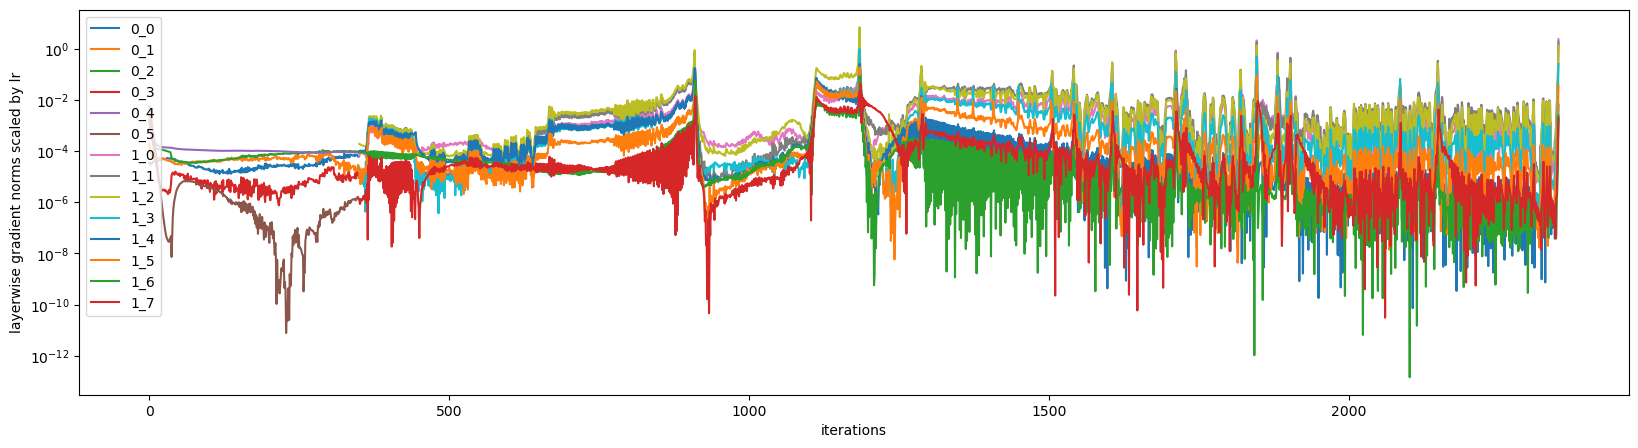

In [ ]:
if True and T2:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms2[0])
    l2 = len(grad_norms2[1])
    len_t1 = len(grad_norms2[0][0])
    len_t2 = len(grad_norms2[1][0])
    for i in range(l1):
        plt.plot(grad_norms2[0][i], label=f'0_{i}')
    for j in range(l2):
        #print(list(range(len_t1,len_t2+len_t1)))
        plt.plot(list(range(len_t1,len_t2+len_t1)), grad_norms2[1][j], label=f'1_{j}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')

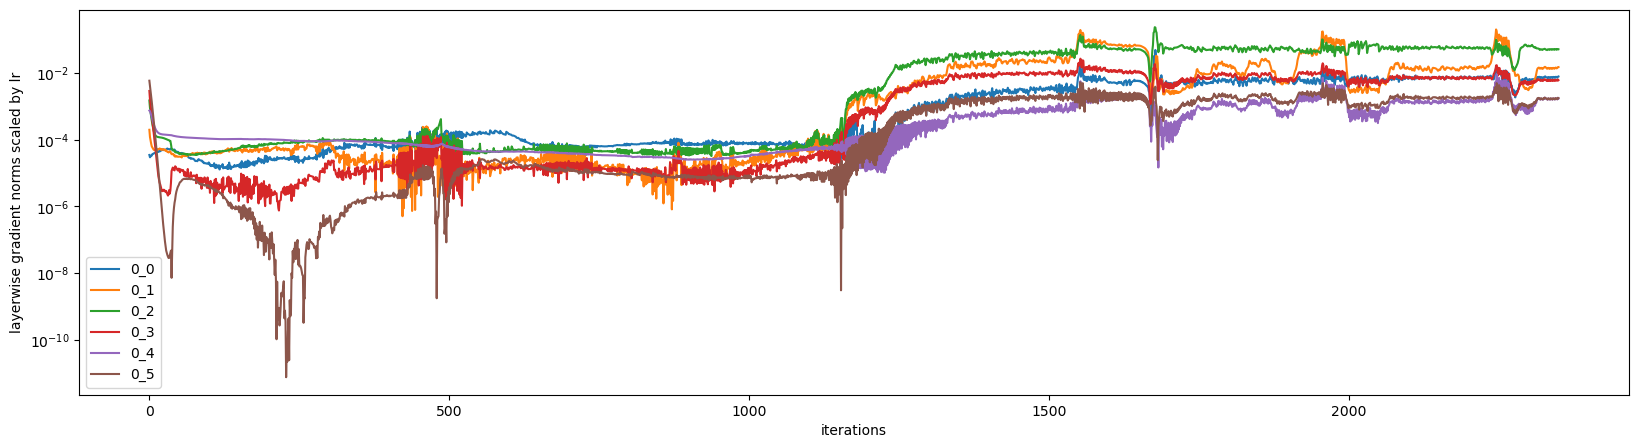

In [ ]:
# classical
if True:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms_classical)
    for i in range(l1):
        plt.plot(grad_norms_classical[i], label=f'0_{i}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')

In [ ]:
from utils import ema2

In [ ]:
smooth_factor = 0.
s1= ema2(mb_losses1, smooth_factor,no_of_steps_back=1000)
if T2:
    s2= ema2(mb_losses2, smooth_factor, no_of_steps_back=1000)
if T3:
    s3 = ema2(mblosses_classical, smooth_factor, no_of_steps_back=1000)

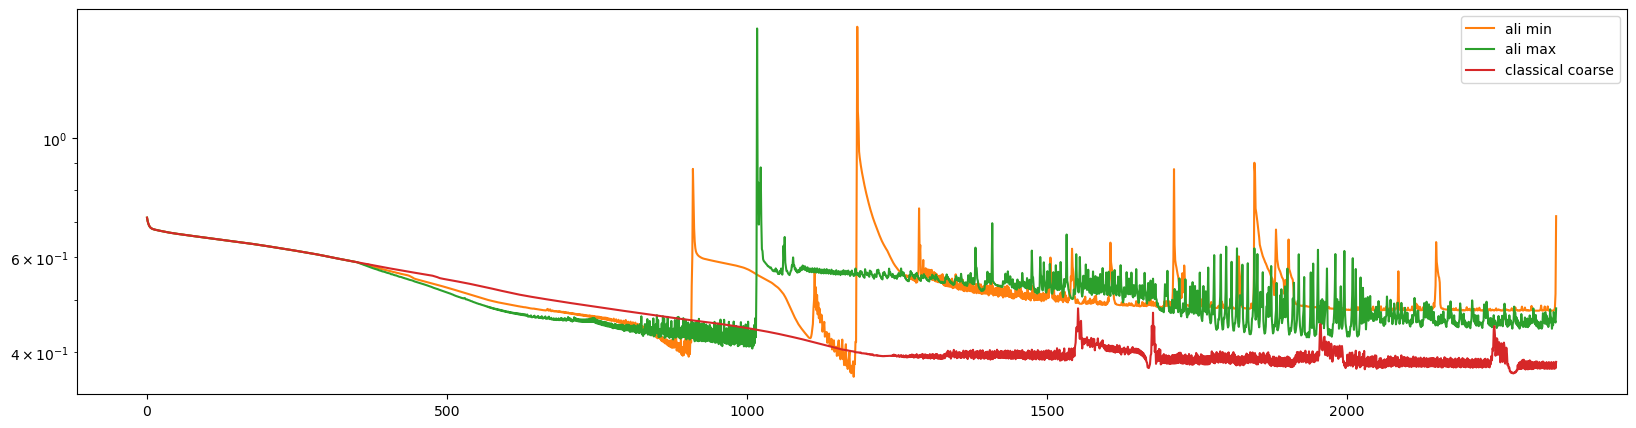

In [ ]:
plt.figure(figsize=(20,5))
if T2:
    plt.plot(np.zeros(max(len(s1),len(s2))))#,len(s3))))

if T2:
    plt.plot(s2, label='ali min')
plt.plot(s1,label='ali max')
if T3:
    plt.plot(s3, label='classical coarse')
plt.yscale('log')

plt.legend()
#plt.ylim((1e-8,1.1))
#plt.xlim((99800,102000))
plt.show()

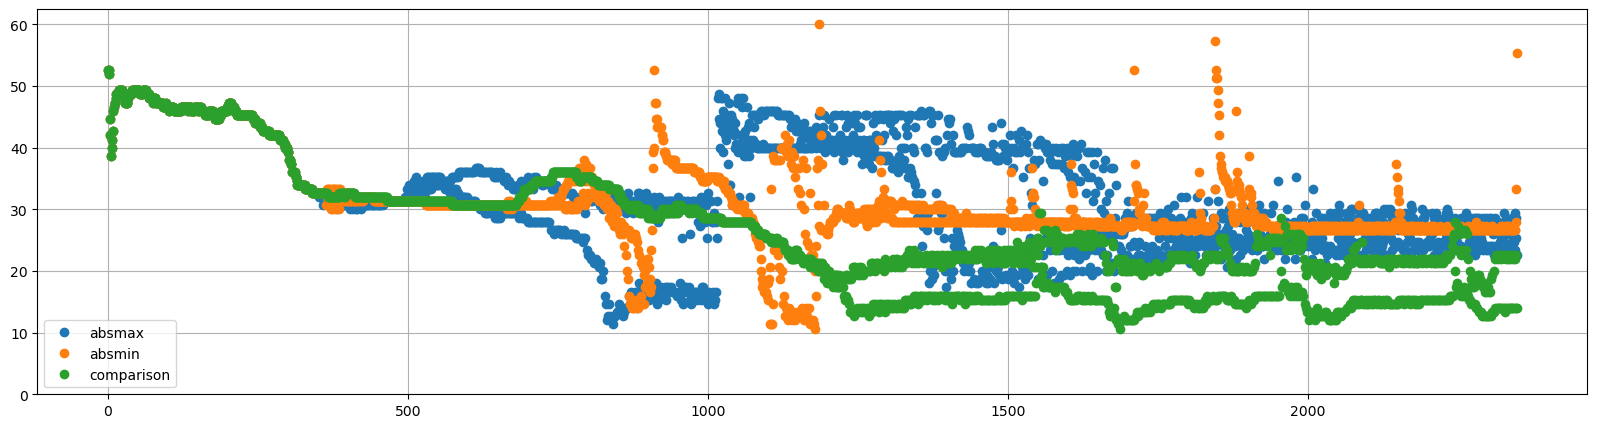

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test_errors1,'o',label='absmax')
if T2:
    plt.plot(test_errors2,'o', label='absmin')
if T3:
    plt.plot(test_error_classical,'o',label='comparison')
plt.grid()
plt.ylim(bottom=0)
plt.legend()